## Planning
# Key Objectives:
1. Clean the data
2. Complete features selection
3. Generate exploratory plots using matplotlib
4. Generate interactive plots using plotly

### Imports and Setup

In [30]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict

plt.style.use("ggplot")

CWD = Path.cwd()
DATA_DIR: Path = CWD.parent / "data"
SURVEY_PATH: Path = DATA_DIR / "survey_results_public.csv"
SURVEY_SCHEMA: Path = DATA_DIR / "survey_results_schema_dropcols.csv"

In [31]:
survey_raw: pd.DataFrame = pd.read_csv(SURVEY_PATH)
survey_schema: pd.DataFrame = pd.read_csv(SURVEY_SCHEMA)

### Preprocessing

In [32]:
def get_column_variants(list1: list, list2: list) -> list:
    return [x for x in list1 if any(y in x and x!=y for y in list2)]


def generate_drop_colnames(stem: str) -> List[str]:
    return stem + "WantToWorkWith", stem + "Admired"


def drop_unwanted_cols(df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop columns using survey schema "drop" column (created manually).
    Additional manual correction was required because some columns didn't map
    / new columns were added compared to the reported schema.
    """
    dropcols = (
        survey_schema
        .loc[survey_schema["drop"] == 1, "qname"]
        .to_list()
    )
    df_columns = df.columns.to_list()  # survey columns don't match schema
    unmatched_colums = list(set(dropcols) - set(df_columns))
    matched_dropcols = [elem for elem in dropcols if elem not in unmatched_colums]
    cols_to_drop_new = get_column_variants(list1=df_columns, list2=dropcols)
    dropcols = matched_dropcols + cols_to_drop_new
    missed_cols = [
        "Language", "Database", "Platform",
        "Webframe", "Embedded", "MiscTech",
        "ToolsTech", "NEWCollabTools", "OfficeStackAsync"
    ]
    dropcols += [x for stem in missed_cols for x in generate_drop_colnames(stem)]
    result = df.drop(columns=dropcols, axis=1, inplace=False)
    return result

In [33]:
# Apply schema to drop columns
df = drop_unwanted_cols(survey_raw)

In [34]:
# Used for a quick look at distribution of categorical cols
df.groupby(["Employment"]).size().sort_values(ascending=False)

Employment
Employed, full-time                                                                                                                                          39041
Independent contractor, freelancer, or self-employed                                                                                                          4846
Student, full-time                                                                                                                                            4709
Employed, full-time;Independent contractor, freelancer, or self-employed                                                                                      3557
Not employed, but looking for work                                                                                                                            2341
                                                                                                                                                             ...  
Student, fu

In [51]:
# Clean and filter the data
# Drop rows where any of the following columns are null
df = drop_unwanted_cols(survey_raw)
salary = df.dropna(subset=["ConvertedCompYearly"])
filter_values: dict = {
    "Check": ["Apples"],
    "MainBranch": ["I am a developer by profession"],
    "Employment": ["Employed, full-time"],
    # May want to reconsider DevType filtering - reduces from ~10k to 500 vals
    "DevType": [
        "Data or business analyst",
        "Data scientist or machine learning specialist",
        "Data or business analyst",
        "Developer, AI"
        ]
}
for k,v in filter_values.items():
    salary = salary[salary[k].isin(v)]
salary = salary.drop([
    "Age", "Employment", "OrgSize", "RemoteWork", "Check", "EdLevel",
    "YearsCode", "Country", "Currency", "CompTotal", "OpSysPersonal use",
    "ICorPM", "WorkExp", "Industry", "YearsCodePro", "MainBranch", 
    "ResponseId", "DevType"
], axis=1)

print(salary.columns)

Index(['LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith',
       'EmbeddedHaveWorkedWith', 'MiscTechHaveWorkedWith',
       'ToolsTechHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'ConvertedCompYearly', 'JobSat'],
      dtype='object')


[array(['I am a developer by profession', 'I am learning to code',
       'I am not primarily a developer, but I write code sometimes as part of my work/studies',
       'I code primarily as a hobby',
       'I used to be a developer by profession, but no longer am'],
      dtype=object)]


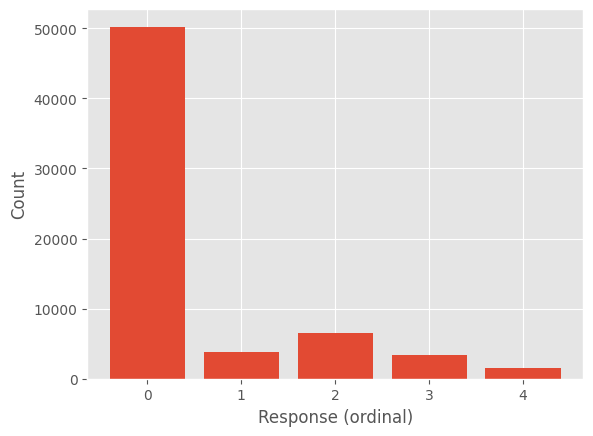

In [52]:
def plot_mainbranch(df: pd.DataFrame) -> None:
    ordinal_encoder = OrdinalEncoder()
    mainbranch_ordinal = (
        ordinal_encoder
        .fit_transform(df["MainBranch"]
                       .to_numpy()
                       .reshape(-1, 1))
    )
    categories_nums, categories_count = np.unique(mainbranch_ordinal, return_counts=True)
    print(ordinal_encoder.categories_)
    plt.bar(
        x=categories_nums,
        height=categories_count,
    )
    plt.xlabel("Response (ordinal)")
    plt.ylabel("Count")
    plt.show()

plot_mainbranch(df)

### Cleaning with Pipelines

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

In [ ]:
# TODO: consider refactoring this into transform on dataframe rather than
# sklearn integration
class PandasDummiesTransformer(BaseEstimator, TransformerMixin):
    """Applies pd.get_dummies in a sklearn pipeline."""
    
    def __init__(self, columns):
        self.columns = columns  # List of categorical columns to transform
        self.dummy_columns = None  # Store column names seen during fitting

    def fit(self, X, y=None):
        """
        Store dummy column names used in training to ensure consistency with
        with test (incase same values aren't in test data).
        """
        all_categories = set()
        for col in self.columns:
            if col in X:
                exploded_values = X[col].dropna().str.split(';').explode()
                all_categories.update([(col, category) for category in exploded_values.unique()])
        
        self.dummy_columns = sorted(all_categories)  # Enforce consistent column order
        return self
    
    def transform(self, X):
        """
        Apply multi-hot encoding with str.get_dummies() and 
        ensure all expected columns exist.
        """
        encoded_dfs = []

        for col in self.columns:
            if col in X:
                encoded = X[col].str.get_dummies(sep=';').add_prefix(f"{col}_")
                encoded_dfs.append(encoded)
        
        if encoded_dfs:
            multi_hot_encoded = pd.concat(encoded_dfs, axis=1)

        missing_cols = [f"{col}_{category}" for col, category in self.dummy_columns if f"{col}_{category}" not in multi_hot_encoded]
        
        if missing_cols:
            missing_df = pd.DataFrame(0, index=X.index, columns=missing_cols)  # Create all missing columns at once
            multi_hot_encoded = pd.concat([multi_hot_encoded, missing_df], axis=1)
        
        return multi_hot_encoded[self.get_feature_names_out()].values  # return as np array
    
    def get_feature_names_out(self, input_features=None):
        """Return the names of the transformed features to keep feature order consistent."""
        return [f"{col}_{category}" for col, category in self.dummy_columns]

In [154]:
# TODO: decide how to fill nulls, develop ColumnTransformer
# Fit linear regression model, random forest regressor, Shapely additive explanations
# Consider mixed effects models
X = salary.drop(columns=['ConvertedCompYearly', "JobSat"])  # Drop labels
y = salary[["ConvertedCompYearly"]]  # Target variable(s)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_attribs = list(X)

In [155]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", PandasDummiesTransformer(cat_attribs), cat_attribs)
    ], remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

In [156]:
pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  PandasDummiesTransformer(columns=['LanguageHaveWorkedWith',
                                                                                    'DatabaseHaveWorkedWith',
                                                                                    'PlatformHaveWorkedWith',
                                                                                    'WebframeHaveWorkedWith',
                                                                                    'EmbeddedHaveWorkedWith',
                                                                                    'MiscTechHaveWorkedWith',
                                                                                    'ToolsTechHaveWorkedWith',
                                                                                    'NEWCollabToolsHaveWorkedWith',
                                                                                    'OpSysProfessional '
                                                                                    'use',
                                                                                    'OfficeStackAsyncHaveWorkedWith']),
                                                  ['LanguageHaveWorkedWith',
                                                   'DatabaseHaveWorkedWith',
                                                   'PlatformHaveWorkedWith',
                                                   'WebframeHaveWorkedWith',
                                                   'EmbeddedHaveWorkedWith',
                                                   'MiscTechHaveWorkedWith',
                                                   'ToolsTechHaveWorkedWith',
                                                   'NEWCollabToolsHaveWorkedWith',
                                                   'OpSysProfessional use',
                                                   'OfficeStackAsyncHaveWorkedWith'])])),
                ('model', LinearRegression())])

In [170]:
result = pd.DataFrame(list(zip(pipeline[0].get_feature_names_out(), pipeline[1].coef_[0])), columns=["skill", "coeff"])
result["coeff_abs"] = result["coeff"].abs()
result = result.sort_values(by="coeff_abs", ascending=False)
result.to_csv("linRegCoeffs.csv")